<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2024/Practica_11_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 10: Modelos de Regresión Lineal Generalizada

En esta clase vamos a ver cómo cargar nuevos modelos de regresión en `Bambi`, yendo más allá y utilizando funciones de verosimilitud que no son Normales. En cierta forma, estamos combinando lo visto en el TP2 (donde ajustabamos distintas funciones de distribución a un set de datos) y el TP3 (donde, para la distribución normal, hacíamos que los parámetros de la distribución sean funciones de variables predictoras).

Nuestro caso de aplicación de ejemplo será la regresión logística o categórica, donde lo que vamos a ajutar es la probabilidad $p$ de pertencer a una determinada categoría, y esta probabilidad depende de distintos predictores.

*Nota: Nada me impediría aplicar estos conceptos a a una distribución de Poisson donde $\lambda$ depende de $x$, a una binomial, etc.*

Empecemos importando las liberías necesarias.

In [1]:
# Instalación e import de Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import io

## Ejercicio 1: Modelado de variables de respuesta categóricas

Para este ejercicio vamos a utilizar el archivo **concrete_test.csv** que contiene distintos ensayos de hormigón y su composición.


### Carga de Datos

In [7]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving concrete_tests.csv to concrete_tests.csv


In [8]:
#Se crea un DataFrame
df_hormigon = pd.read_csv(io.BytesIO(uploaded['concrete_tests.csv']))
df_hormigon.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [9]:
# Vemos el tipo de dato y si existen nulos
df_hormigon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Cement                              103 non-null    float64
 1   Slag                                103 non-null    float64
 2   Fly ash                             103 non-null    float64
 3   Water                               103 non-null    float64
 4   SP                                  103 non-null    float64
 5   Coarse Aggr.                        103 non-null    float64
 6   Fine Aggr.                          103 non-null    float64
 7   SLUMP(cm)                           103 non-null    float64
 8   FLOW(cm)                            103 non-null    float64
 9   Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB


In [10]:
df_hormigon.rename(columns={
  'Fly ash': "Fly_ash",
  'SP': "Superplasticizer",
  'Coarse Aggr.': "Coarse_aggr",
  'Fine Aggr.': "Fine_aggr",
  'SLUMP(cm)': 'Slump_cm',
  'FLOW(cm)': 'Flow_cm',
  'Compressive Strength (28-day)(Mpa)': "CompressiveStrength"
                     },
            inplace=True)

Si bien el dataset contiene variables cuantificables, vamos a llevar a cabo modelos donde nuestra **variable de respuesta es categórica**, pero el abordaje será distinto dependiendo del problema.

### Modelo 1: Regresión logística

Supongamos la siguiente situación: en vez de tener la columna **CompressiveStrength**, tenemos **Strength_Category** con una variable categórica binaria: **<40MPa** y **>=40MPa**. Nuestro objetivo será predecir

si nuestro hormigón es de alta resistencia o no.

In [11]:
df_hormigon.loc[df_hormigon['CompressiveStrength'] < 40, 'Strength_Category'] = "<40MPa"
df_hormigon.loc[df_hormigon['CompressiveStrength'] >= 40, 'Strength_Category'] = ">=40MPa"

# Transformamos en categórica
df_hormigon['Strength_Category'] = df_hormigon['Strength_Category'].astype('category')

# No utilizamos la columna de resistencia (la borro):
df_1 = df_hormigon[['Cement', 'Slag', 'Fly_ash', 'Water', 'Superplasticizer', 'Coarse_aggr', 'Fine_aggr', 'Slump_cm', 'Flow_cm', 'Strength_Category']]
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Cement             103 non-null    float64 
 1   Slag               103 non-null    float64 
 2   Fly_ash            103 non-null    float64 
 3   Water              103 non-null    float64 
 4   Superplasticizer   103 non-null    float64 
 5   Coarse_aggr        103 non-null    float64 
 6   Fine_aggr          103 non-null    float64 
 7   Slump_cm           103 non-null    float64 
 8   Flow_cm            103 non-null    float64 
 9   Strength_Category  103 non-null    category
dtypes: category(1), float64(9)
memory usage: 7.6 KB


#### EDA

Realicemos algunas visualizaciones para decidir qué variables son posibles predictores para establecer la categoría de resistencia del hormigón:

Podemos empezar por un heatmap...

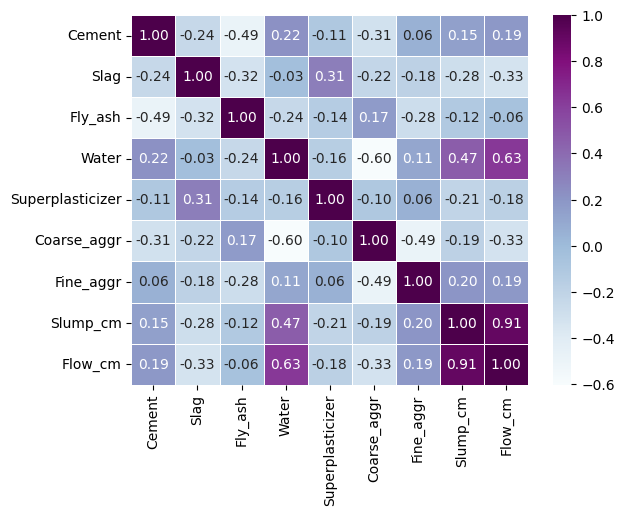

In [14]:
features = ['Cement', 'Slag', 'Fly_ash', 'Water', 'Superplasticizer', 'Coarse_aggr', 'Fine_aggr', 'Slump_cm', 'Flow_cm']

# Gráfico de calor para la matriz de correlación
sns.heatmap(df_1[features].corr(), cmap='BuPu', fmt='.2f', annot=True, linewidths=.6)
plt.show()

O, mejor aún, con un pair-plot...

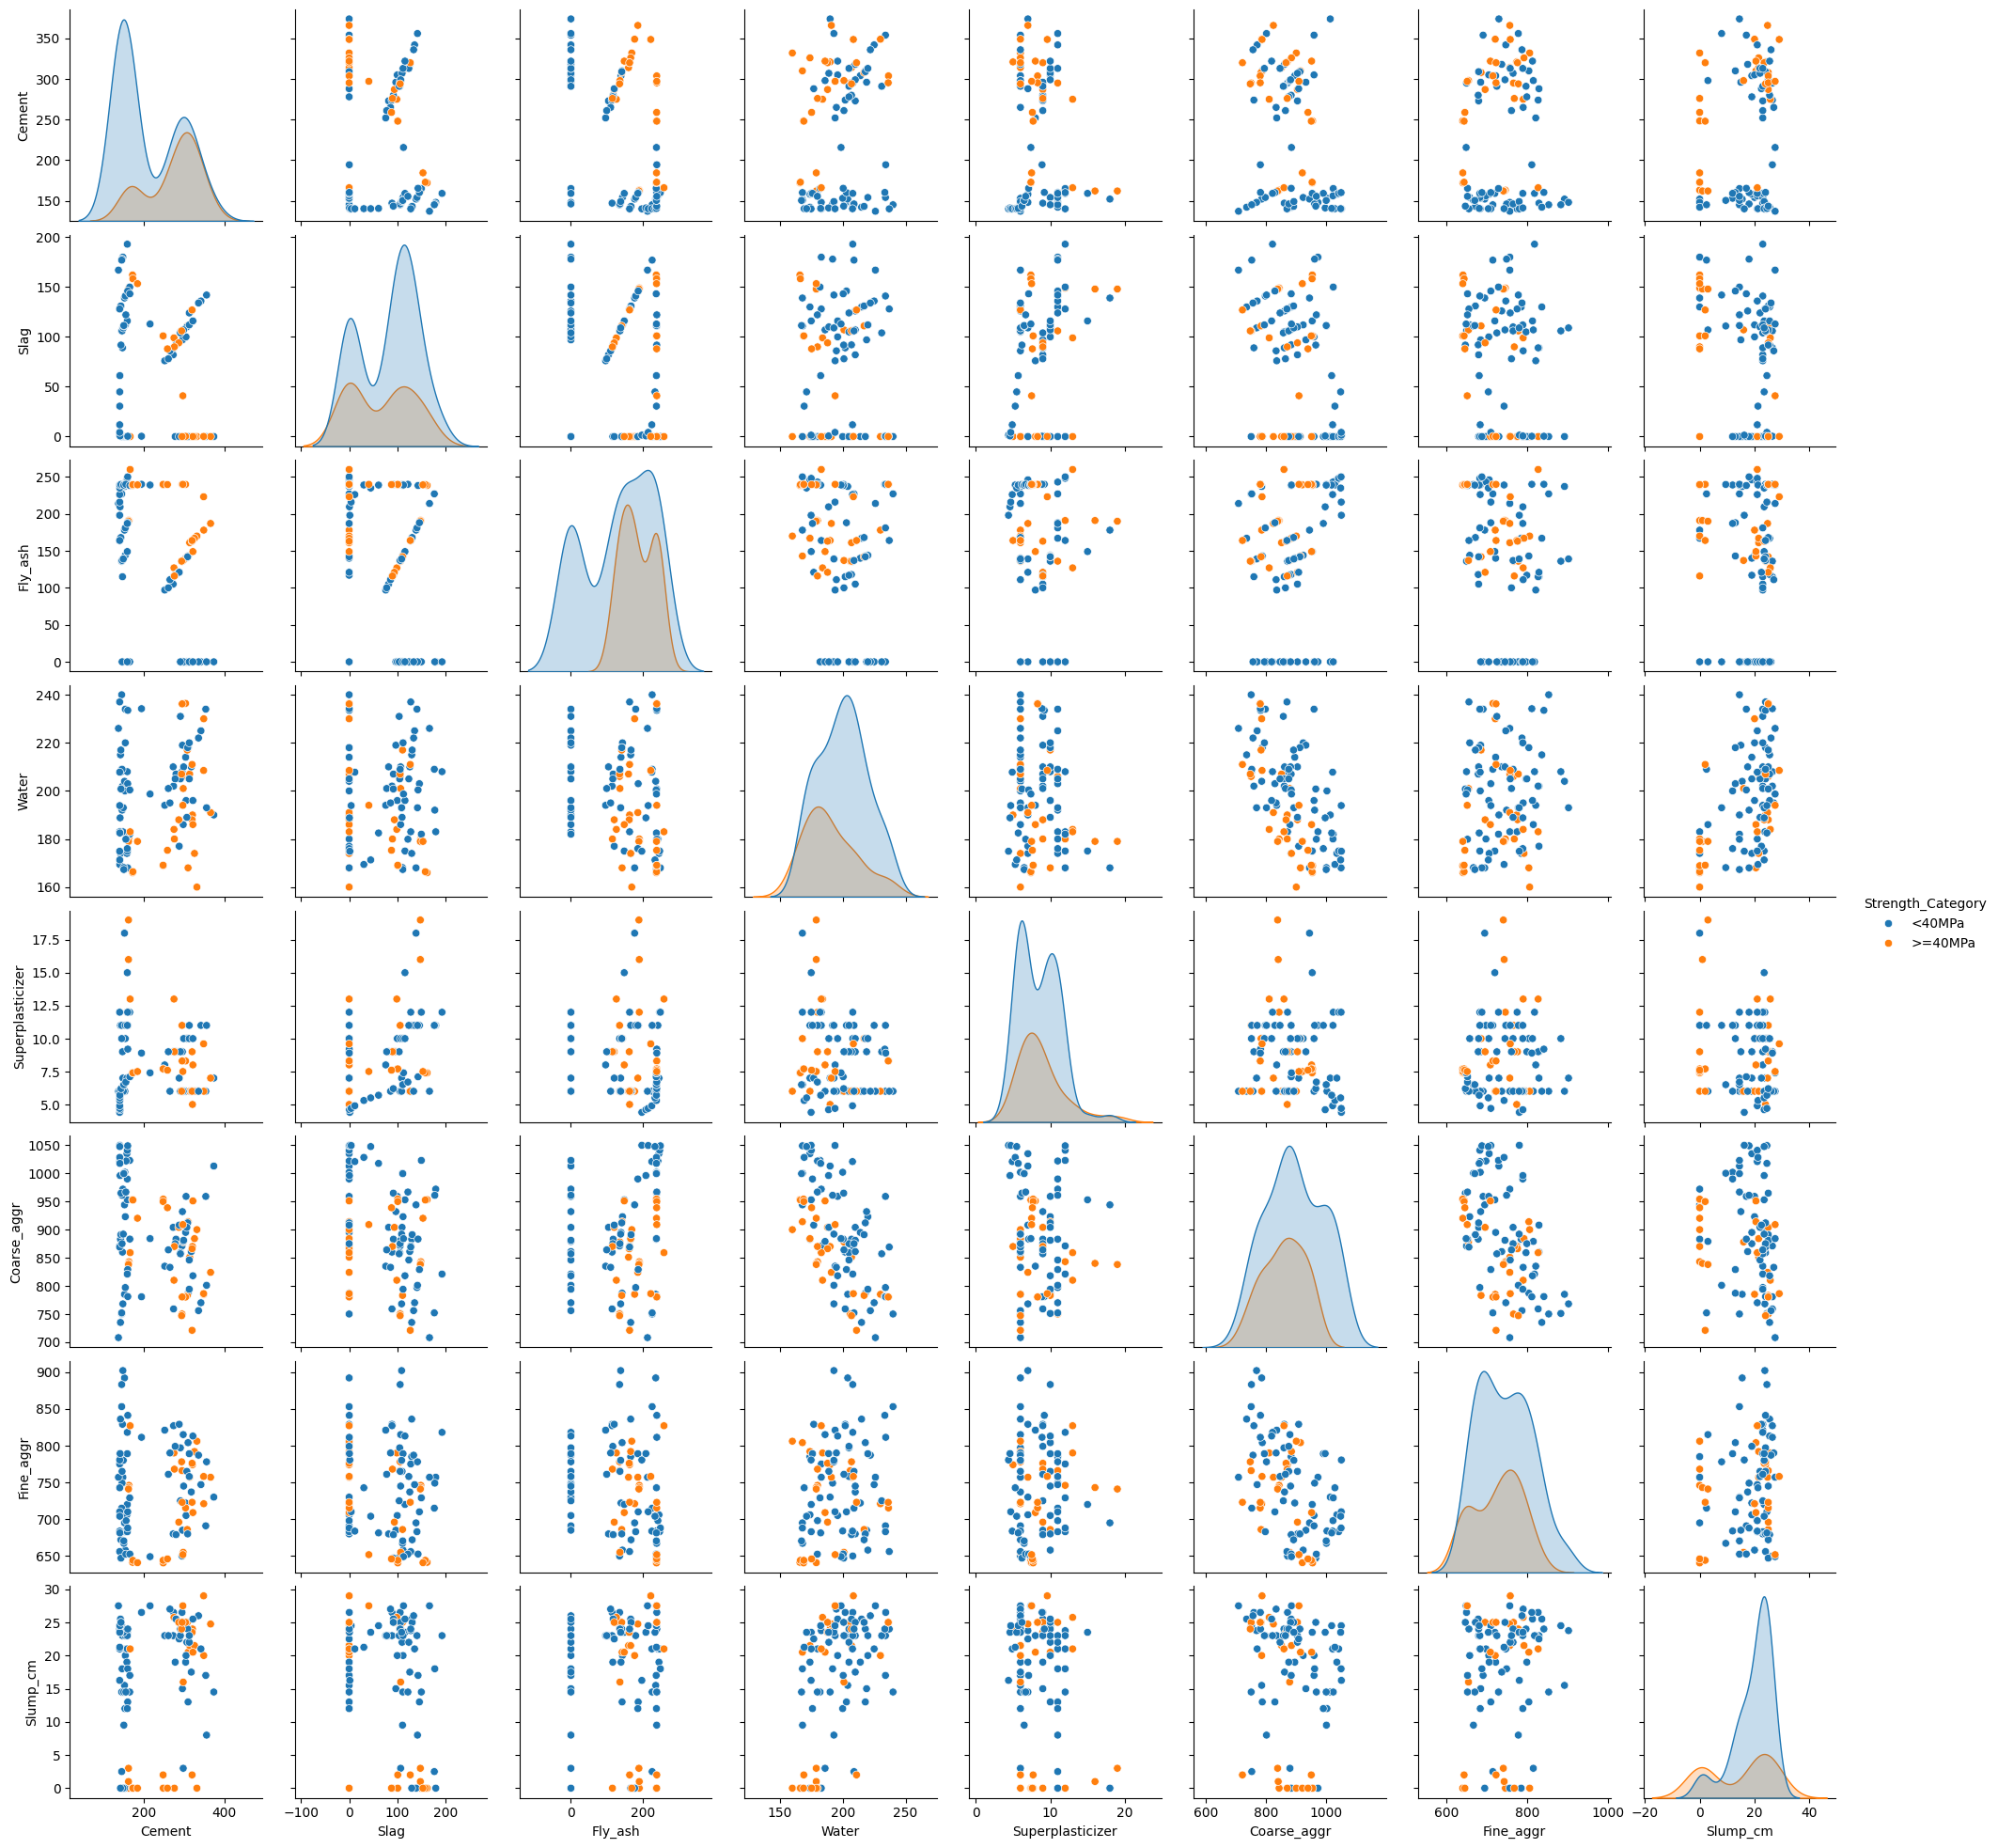

In [15]:
features = ['Cement', 'Slag', 'Fly_ash', 'Water', 'Superplasticizer', 'Coarse_aggr', 'Fine_aggr', 'Slump_cm', 'Strength_Category']

# Grilla de gráficos de puntos
sns.pairplot(df_1[features], hue='Strength_Category')
plt.show()

Algunas alternativas donde podemos ver más claramente cada categoría (¡recuerden igual que es importante combinarlas!):

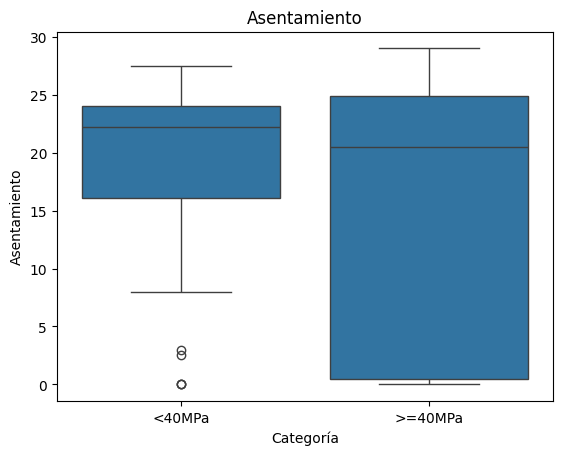

In [16]:
sns.boxplot(y='Slump_cm', x='Strength_Category', data=df_1).set(
    title = 'Asentamiento', xlabel='Categoría', ylabel='Asentamiento')
plt.show()

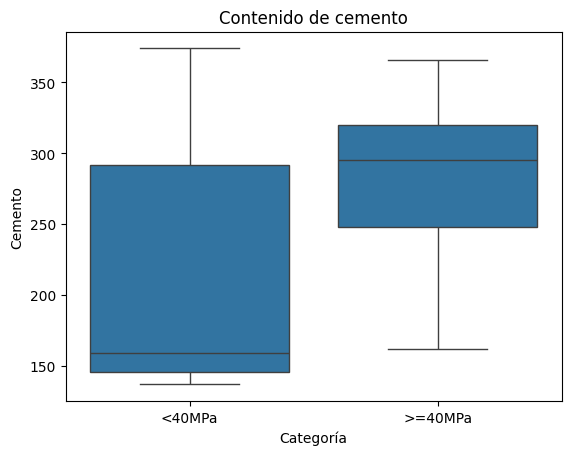

In [18]:
sns.boxplot(y='Cement', x='Strength_Category', data=df_1).set(
    title = 'Contenido de cemento', xlabel='Categoría', ylabel='Cemento')
plt.show()

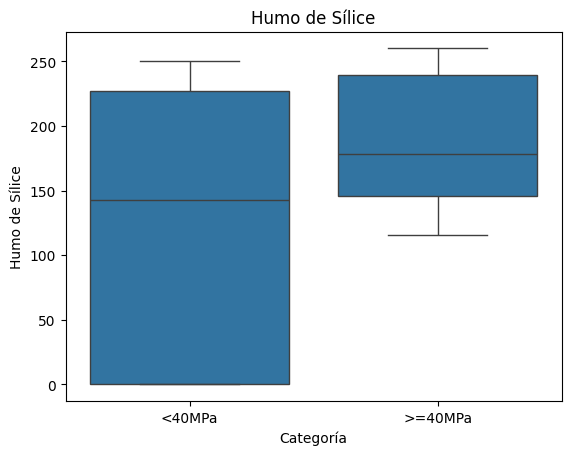

In [19]:
sns.boxplot(y='Fly_ash', x='Strength_Category', data=df_1).set(
    title = 'Humo de Sílice', xlabel='Categoría', ylabel='Humo de Sílice')
plt.show()

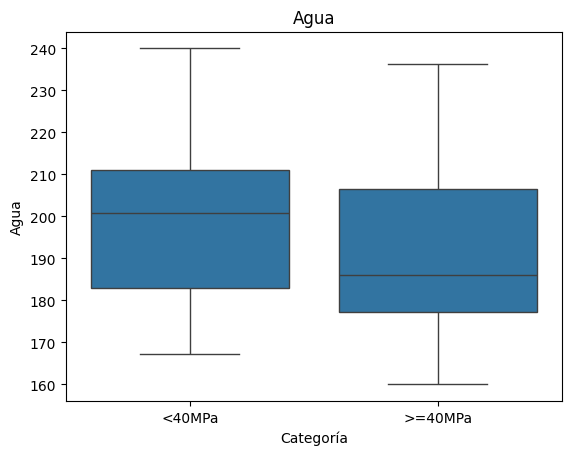

In [20]:
sns.boxplot(y='Water', x='Strength_Category', data=df_1).set(
    title = 'Agua', xlabel='Categoría', ylabel='Agua')
plt.show()

¡Acá les dejamos algunos ejemplos para ver cómo se combinan las variables!

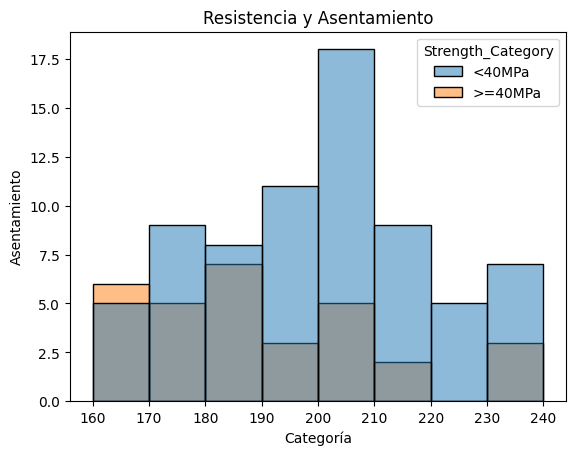

In [21]:
sns.histplot(data=df_1, x='Water', hue='Strength_Category').set(
    title = 'Resistencia y Asentamiento', xlabel='Categoría', ylabel='Asentamiento')
plt.show()

Veamos un poco los datos: recuerde que si los rangos de las distintas variables son muy diversas, es recomendable estandarizar para facilitar la convergencia:

In [ ]:
df_1.describe()

,Cement,Slag,Fly_ash,Water,Superplasticizer,Coarse_aggr,Fine_aggr,Slump_cm,Flow_cm
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.00000
mean,229.894175,77.973786,149.014563,197.167961,8.539806,883.978641,739.604854,18.048544,49.61068
std,78.877230,60.461363,85.418080,20.208158,2.807530,88.391393,63.342117,8.750844,17.56861
min,137.000000,0.000000,0.000000,160.000000,4.400000,708.000000,640.600000,0.000000,20.00000
25%,152.000000,0.050000,115.500000,180.000000,6.000000,819.500000,684.500000,14.500000,38.50000
50%,248.000000,100.000000,164.000000,196.000000,8.000000,879.000000,742.700000,21.500000,54.00000
75%,303.900000,125.000000,235.950000,209.500000,10.000000,952.800000,788.000000,24.000000,63.75000
max,374.000000,193.000000,260.000000,240.000000,19.000000,1049.900000,902.000000,29.000000,78.00000


Las variables que utilizaremos son:

In [ ]:
features = ['Cement', 'Fly_ash', 'Slump_cm', 'Water']

#### Modelado


Nuestro objetivo final es, utilizando nuestro entendimiento del problema, modelar Y con uno o más de los predictores anteriores.

De manera similar a como hicimos en clases anteriores, tenemos que indicarle a bambi:
- Las prioris,
- El DataFrame con los datos,
- La familia: **Bernoulli** ya que Y es un indicador binario de algún evento de interés que ocurre con una cierta probabilidad
- la fórmula: en el lado izquierdo, indicamos que queremos conocer la probabilidad de que **Strength_Category** es **'>=40MPa'**, mientras que en el lado derecho, indicamos las variables explicativas del modelo y sus interacciones:

##### Modelo 1 (simple)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p) = A + B \cdot Cement + C \cdot Fly\_ash + D \cdot Slump\_cm \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p$ se calcula como:

$$p = \frac{1}{1+e^{-(A + B \cdot Cement + C \cdot Fly\_ash + D \cdot Slump\_cm)}}$$

In [22]:
model_1 = bmb.Model("Strength_Category['>=40MPa'] ~ Cement + Fly_ash + Slump_cm", df_1, family="bernoulli")
fitted_1 = model_1.fit(draws=2000, chains=4, target_accept=0.85, idata_kwargs={"log_likelihood": True})

Output()

Output()

Output()

Output()

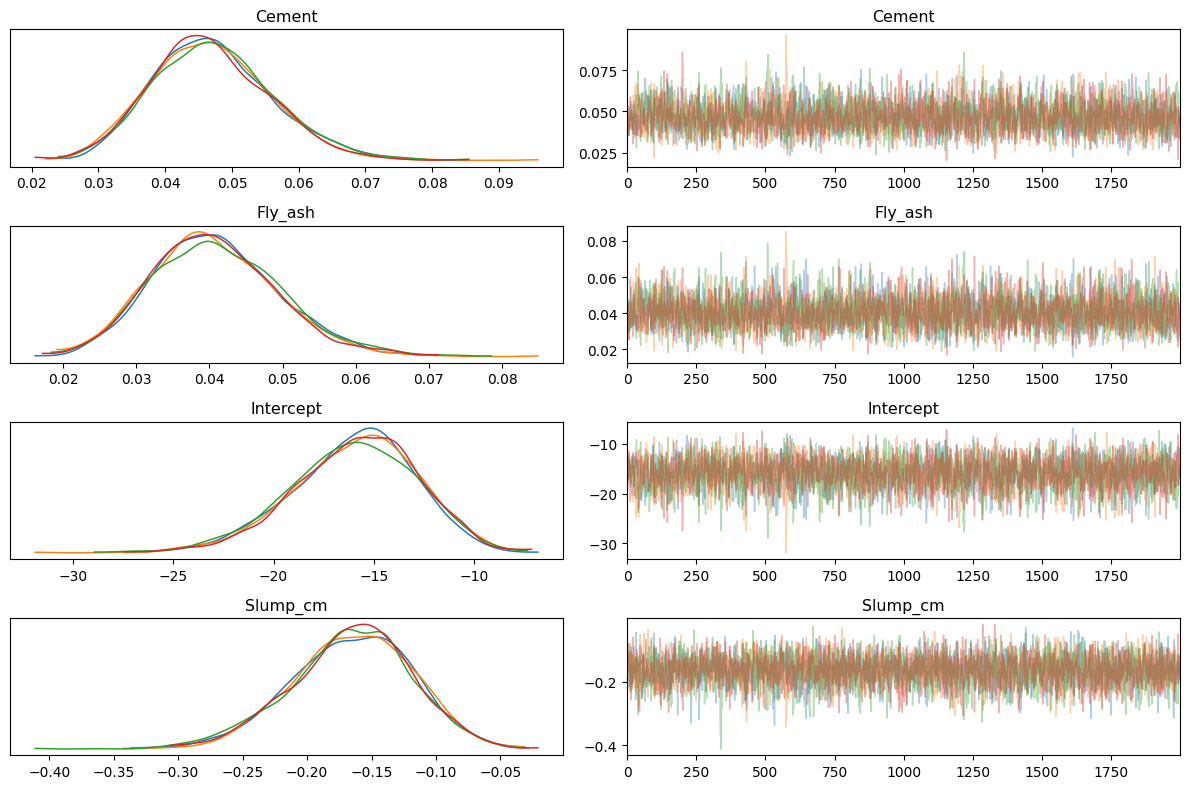

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Cement,0.047,0.009,0.030,0.063,0.000,0.000,2849.0,3890.0,1.0
Fly_ash,0.041,0.009,0.024,0.057,0.000,0.000,3072.0,3890.0,1.0
Intercept,-15.951,3.098,-21.781,-10.339,0.057,0.041,3015.0,3251.0,1.0
Slump_cm,-0.166,0.047,-0.255,-0.080,0.001,0.001,3617.0,3651.0,1.0


In [27]:
az.plot_trace(fitted_1,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_1)

##### Modelo 2 (simple)

Probemos otros modelos, por ejemplo agregando una variable explicativa

In [28]:
model_2 = bmb.Model("Strength_Category['>=40MPa'] ~ Cement + Fly_ash + Water + Slump_cm", df_1, family="bernoulli")
fitted_2 = model_2.fit(draws=2000, chains=4, target_accept=0.85, idata_kwargs={"log_likelihood": True})

Output()

Output()

Output()

Output()

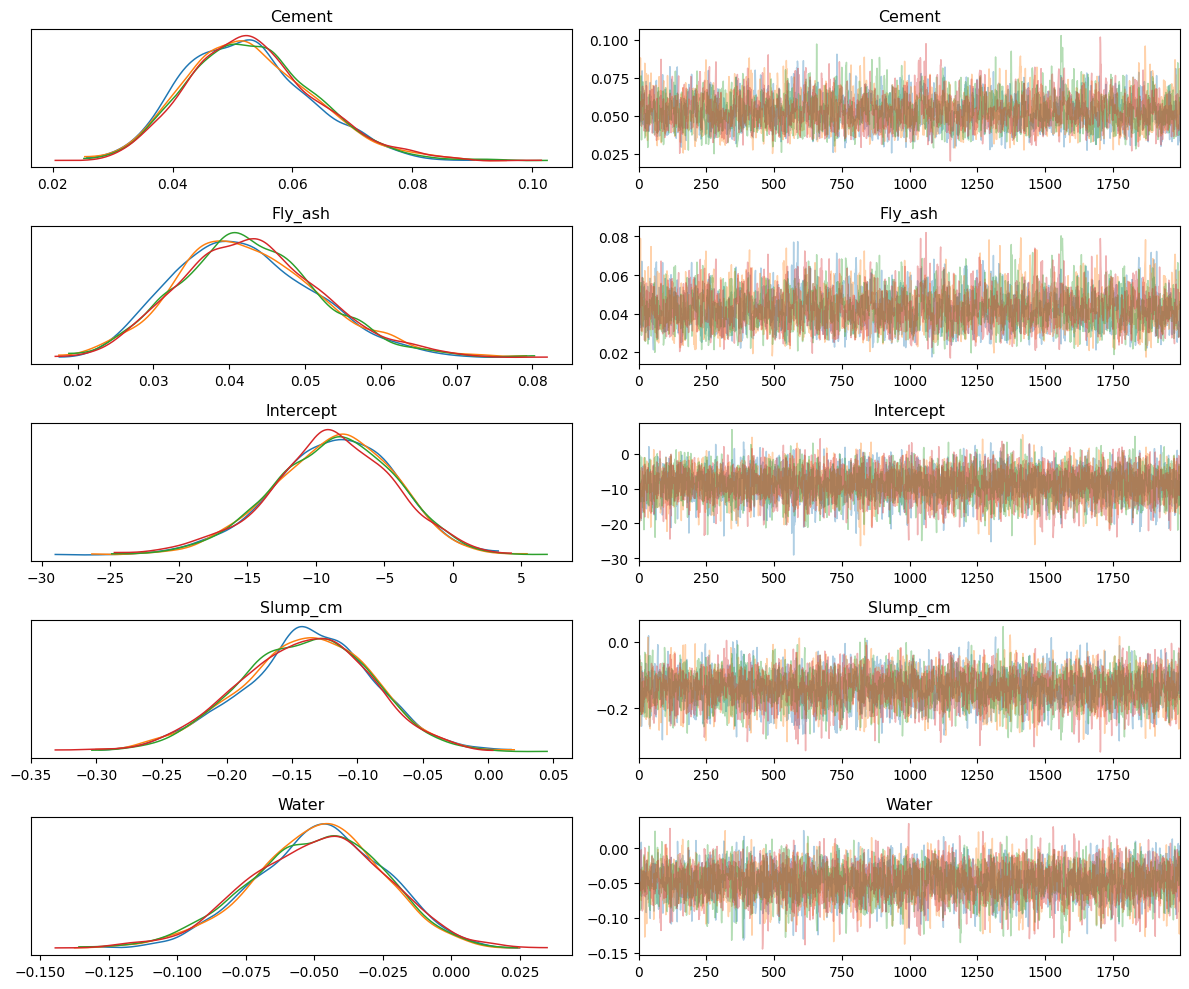

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Cement,0.053,0.011,0.034,0.073,0.000,0.000,2705.0,3509.0,1.0
Fly_ash,0.043,0.010,0.025,0.060,0.000,0.000,2799.0,3318.0,1.0
Intercept,-8.751,4.484,-17.143,-0.377,0.059,0.044,5979.0,5663.0,1.0
Slump_cm,-0.140,0.051,-0.245,-0.052,0.001,0.001,3828.0,4522.0,1.0
Water,-0.049,0.025,-0.094,-0.002,0.000,0.000,4936.0,4803.0,1.0


In [29]:
az.plot_trace(fitted_2,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_2)

##### Modelo 3 (creando nuevas variables)

Existe la posibilidad de que se quiera crear una nueva variable predictora que no necesariamente se encuentre en el dataframe. Por ejemplo, en el dataset anterior no se informa la relación Agua-Cemento, pero queremos usarla de predictor para $p$ (la probabilidad de que un hormigón sea de alta resistencia o no).

- Una opción sería crear una columna en el dataframe, y luego llamarla en la fórmula como una variable cualquiera (¡a veces conviene esto!)
- Otra opción es incluir la expresión de generación de la nueva variable en la fórmula mismo, haciendo uso de llaves `{}`.

Por ejemplo, si quiero usar la relación agua cemento, puedo incluir en la fórmula `{Water/Cement}`, y ¡listo!


In [35]:
model_3 = bmb.Model("Strength_Category['>=40MPa'] ~ Cement + Fly_ash + Water + Slump_cm + {Water/Cement}", df_1, family="bernoulli")
fitted_3 = model_3.fit(draws=2000, chains=4, target_accept=0.85, idata_kwargs={"log_likelihood": True})

Output()

Output()

Output()

Output()

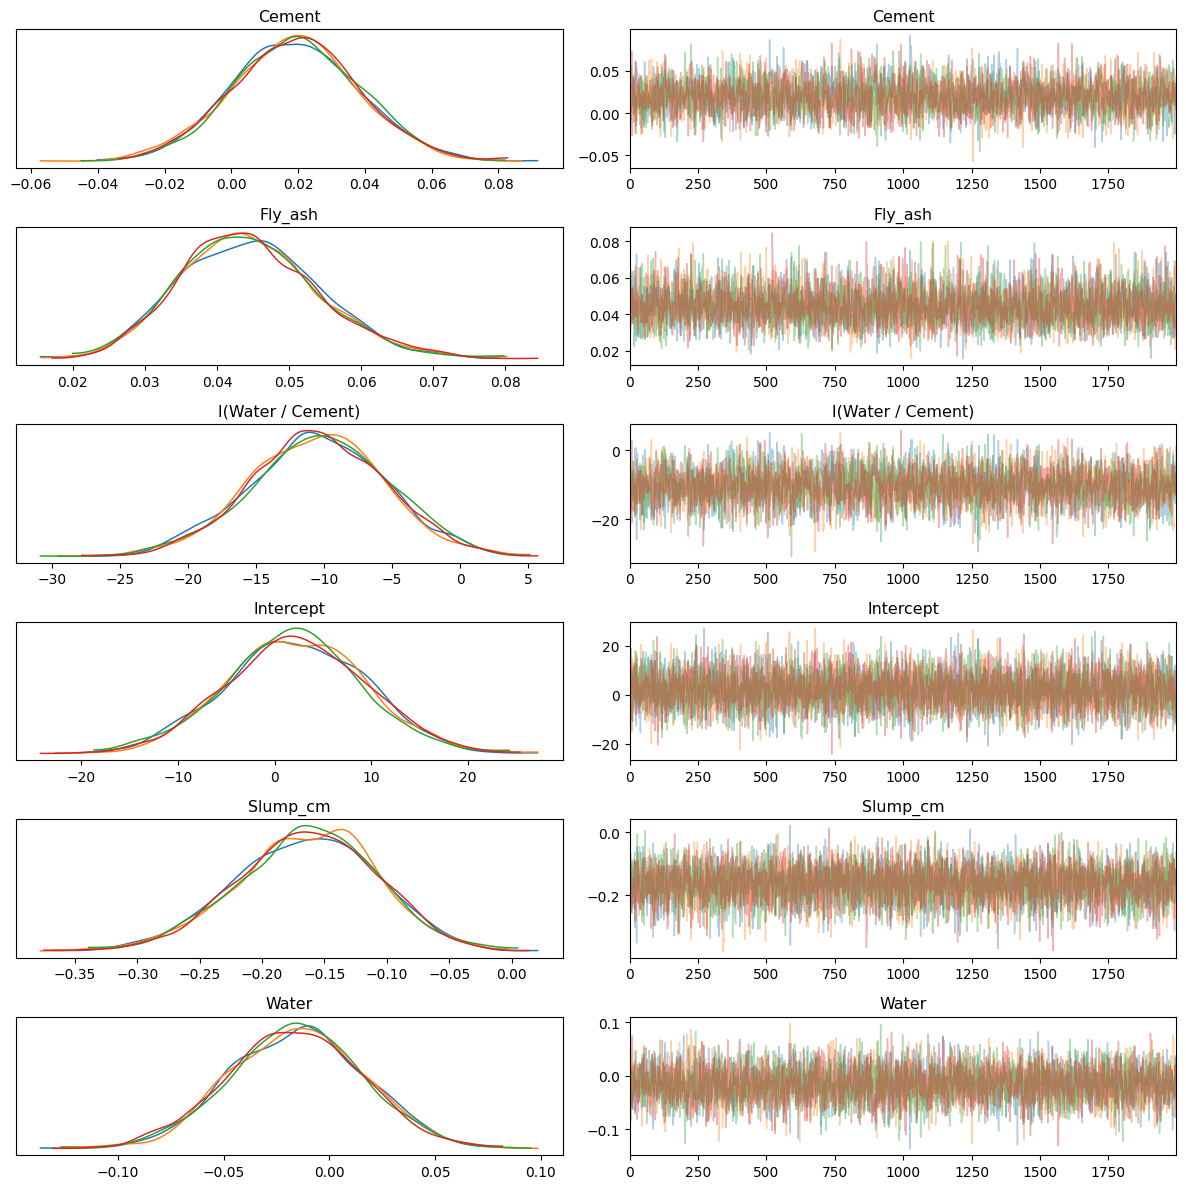

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Cement,0.019,0.019,-0.017,0.055,0.000,0.000,3442.0,4185.0,1.0
Fly_ash,0.045,0.010,0.027,0.063,0.000,0.000,3763.0,4871.0,1.0
I(Water / Cement),-10.457,4.989,-20.444,-1.467,0.086,0.061,3372.0,4136.0,1.0
Intercept,2.150,7.190,-10.814,16.284,0.097,0.073,5450.0,5709.0,1.0
Slump_cm,-0.164,0.056,-0.271,-0.061,0.001,0.001,4866.0,5060.0,1.0
Water,-0.016,0.032,-0.072,0.047,0.000,0.000,4201.0,4822.0,1.0


In [31]:
az.plot_trace(fitted_3,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_3)

##### Modelo 4 (y algunos comentarios adicionales)

Abajo les dejamos un modelo más, con menos variables (eliminamos la influencia del cemento y el agua por separado, porque creemos que el efecto está asociado al $a/c$.

Sí queremos remarcar que esta forma de crear variables muy útil, por ejemplo para:

- Incluir variables deteminísticas: Por ejemplo, que la $varianza$ $\sigma^{2}$ de los datos es la suma de la varianza del suelo explicada según la variable `tipo de suelo` ${\sigma_{s}}^{2}$ (desconocida) y la varianza del ensayo ${\sigma_{test}}^{2}$ que es dato.
- Ajustar parábolas o polinomios que dependen de la variable explicativa.
- Fijar parámetros de la ecuación (por ejemplo, debido a que la deducción matemática indica un valor específico).


Otras opciones disponibles vistas anteriormente fueron:
- hacer variables interactuar (por ejemplo, que la pendiente de la recta $y = A \cdot x$ es una función de la variable categórica $X_{2}$: $y = A_{X_{2}} \cdot x$ (en `Bambi`, haciendo `x1:x2`
- Crear polinomios en forma más eficiente en vez de escribir todo (y usa una formulación que lleva a menor error): `poly(x,p)`, donde `p` es el orden del polinomio.
- Escalar los datos para cuando las variables predictores tienen rangos muy distintos: `scale(x)` en la fórmula de Bambi.

Les recomendamos ver cómo se hace en la documentación: https://bambinos.github.io/formulae/notebooks/getting_started.html

In [32]:
model_4 = bmb.Model("Strength_Category['>=40MPa'] ~ Fly_ash + Slump_cm + {Water/Cement}", df_1, family="bernoulli")
fitted_4 = model_4.fit(draws=2000, chains=4, target_accept=0.85, idata_kwargs={"log_likelihood": True})

Output()

Output()

Output()

Output()

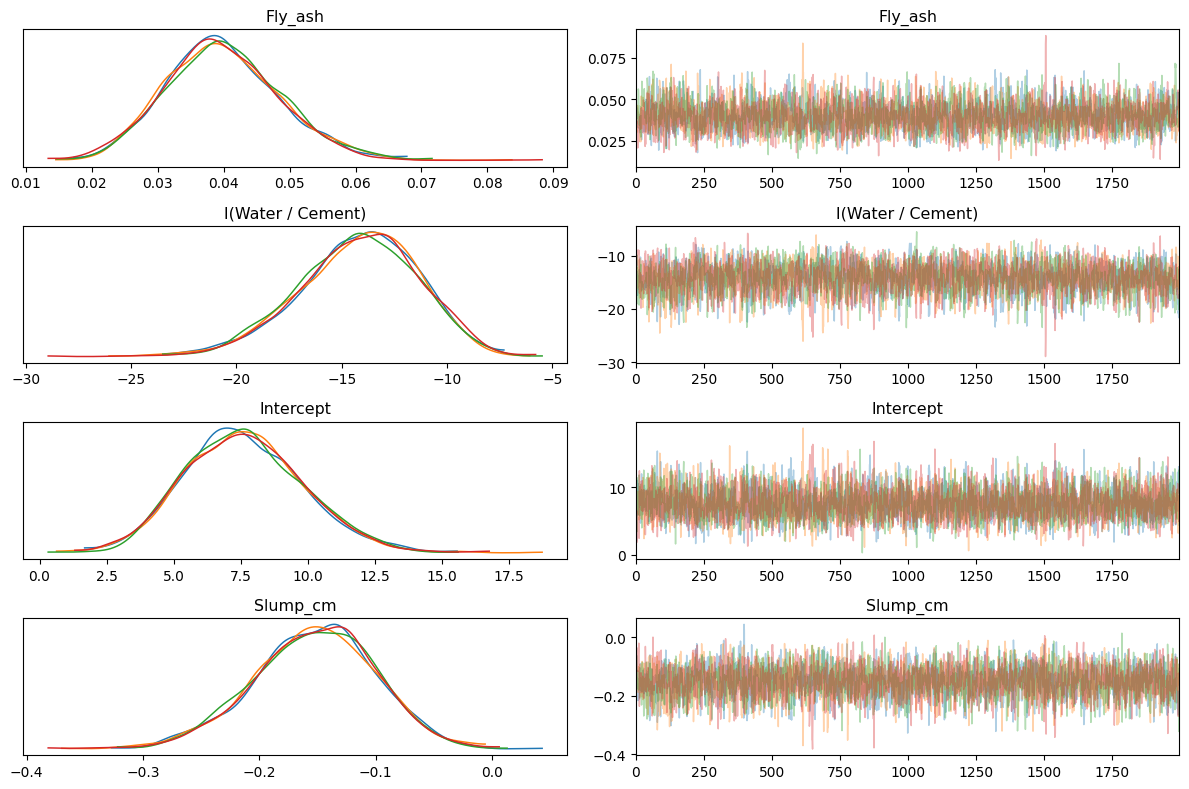

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Fly_ash,0.040,0.009,0.024,0.056,0.000,0.000,2695.0,4043.0,1.0
I(Water / Cement),-14.195,2.820,-19.692,-9.264,0.056,0.040,2396.0,3795.0,1.0
Intercept,7.625,2.207,3.667,11.837,0.037,0.026,3595.0,5294.0,1.0
Slump_cm,-0.153,0.052,-0.253,-0.057,0.001,0.001,3255.0,3846.0,1.0


In [33]:
az.plot_trace(fitted_4,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_4)

#### Comparando los modelos

Como ya vimos, con `Arviz` podemos comparar la capacidad predictiva 'out-of-sample' estimada de los modelos para elegir:

In [36]:
models_dict = {
    "model_1": fitted_1,
    "model_2": fitted_2,
    "model_3": fitted_3,
    "model_4": fitted_4
}

df_compare = az.compare(models_dict)
df_compare

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_4,0,-24.088804,2.916039,0.000000,1.000000e+00,4.054030,0.000000,False,log
model_3,1,-25.586384,4.357596,1.497580,5.995204e-15,4.542805,0.679330,True,log
model_2,2,-26.814670,3.917465,2.725866,1.332268e-15,4.537674,1.150779,False,log
model_1,3,-28.162976,3.156719,4.074173,0.000000e+00,5.059945,2.231921,False,log


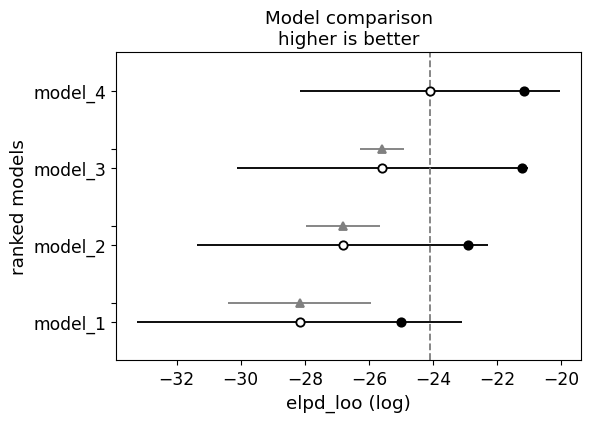

In [39]:
az.plot_compare(df_compare, insample_dev=True,plot_ic_diff=True);

Y con esto podríamos elegir un modelo entre los que planteamos. ¿Cuál usarían ustedes?

#### Análisis/Visualización del Modelo

Bueno, ya tenemos un modelo seleccionado, pero ¿cómo funciona? Con la regresión logística a veces es dificil entender qué significa porque lo que se ajusta es una función logit.

El objetivo es ver ahora cómo usarlo y entenderlo.

Lo primero es: ¿Cómo influye cada variable en la probabilidad de ser de alta resistencia?

Lo primero que podríamos hacer es un test de hipótesis: ¿La variable es signifcativa? Analizando si la constante que afecta al predictor es distinto de 0 podemos contestarlo:

Por ejemplo, para la influencia de la relación Agua-Cemento:

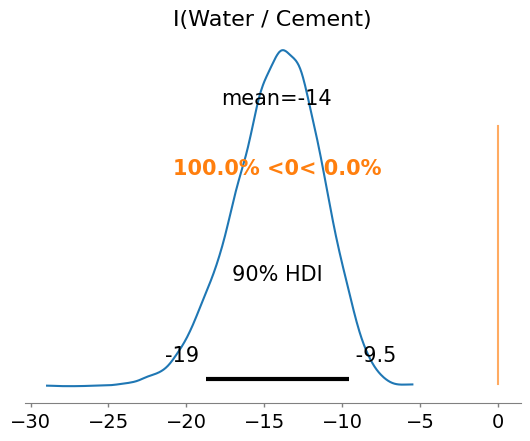

In [43]:
az.plot_posterior(fitted_4,var_names='I(Water / Cement)',ref_val=0,hdi_prob=0.9)
plt.show()

¿Cree que es significativo para definir si el hormigón es de alta resistencia?

Abajo se muestra lo mismo para el asentamiento. ¿Qué opina?

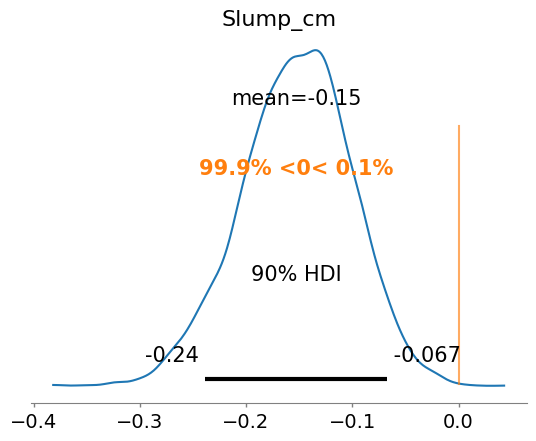

In [46]:
az.plot_posterior(fitted_4,var_names='Slump_cm',ref_val=0,hdi_prob=0.9)
plt.show()

Otra opción es ver directamente cómo influyen las variables predictoras en el cálculo de $p$. La mejor forma es hacerlo gráficamente con `bmb.interpret.plot_predictions`.

Otra opción útil es simulando para valores nuevos valores de los datos. Por ejemplo, ¿cuánto vale $p$ cuándo el no hay fly_ash y el asentamiento es bajo (5cm) o alto (15cm), en función de la relación agua/cemento?

Para eso, primero generamos un dataframe con los datos que queremos simular:

In [56]:
# Datos nuevos (no vistos)
Cement = 1 # así Water es la relacion Agua Cemento Directamente, no influye
Water = np.linspace(0,1,101)
Fly_ash = 0
Slump_cm = np.array([5,15])

# Construcción del dataframe
df_A =  pd.DataFrame({'Cement':Cement*np.ones(Water.shape),'Water':Water,'Fly_ash':Fly_ash*np.ones(Water.shape),'Slump_cm':Slump_cm[0]*np.ones(Water.shape)})
df_B = pd.DataFrame({'Cement':Cement*np.ones(Water.shape),'Water':Water,'Fly_ash':Fly_ash*np.ones(Water.shape),'Slump_cm':Slump_cm[1]*np.ones(Water.shape)})
df_2 = pd.concat([df_A,df_B])
df_2

,Cement,Water,Fly_ash,Slump_cm
0,1.0,0.00,0.0,5.0
1,1.0,0.01,0.0,5.0
2,1.0,0.02,0.0,5.0
3,1.0,0.03,0.0,5.0
4,1.0,0.04,0.0,5.0
...,...,...,...,...
96,1.0,0.96,0.0,15.0
97,1.0,0.97,0.0,15.0
98,1.0,0.98,0.0,15.0
99,1.0,0.99,0.0,15.0


Luego, simulamos valores de $p$ para cada uno de estos casos (nota, si quiseran la posterior predictiva también puden aclarandolo al llamar la función)

In [59]:
new_fitted = model_4.predict(fitted_4,data=df_2,inplace=False)

new_fitted

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Y ahora podemos graficar estas simulaciones con las funciones típicas de arviz (plot_hdi) y matplotlib!

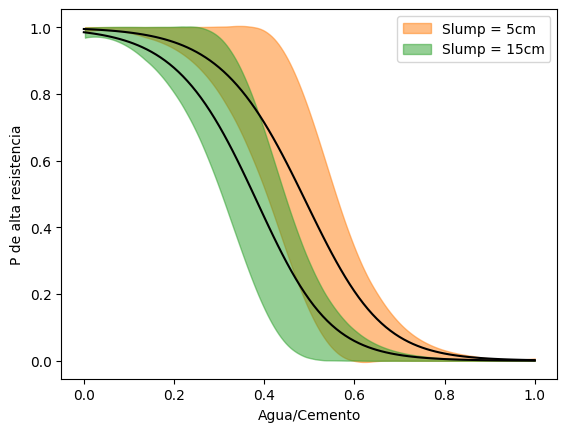

In [124]:
# Construyo gráfico con posterior de #p# en funcion de a/c para slump=5
ax = az.plot_hdi(df_2[df_2['Slump_cm']==5]['Water'],new_fitted.posterior['p'][:,:,df_2['Slump_cm']==5],hdi_prob=0.8)

# agrego valor medio/posterior predictiva de p
plt.plot(df_2[df_2['Slump_cm']==5]['Water'],np.mean(new_fitted.posterior['p'][:,:,df_2['Slump_cm']==5],axis=(0,1)),'k-')

# Repito para slump = 15
az.plot_hdi(df_2[df_2['Slump_cm']==15]['Water'],new_fitted.posterior['p'][:,:,df_2['Slump_cm']==15],hdi_prob=0.8,color='C2',ax=ax)

# agrego valor medio/posterior predictiva de p
plt.plot(df_2[df_2['Slump_cm']==15]['Water'],np.mean(new_fitted.posterior['p'][:,:,df_2['Slump_cm']==15],axis=(0,1)),'k-')

# Agrego datos al gráfico
plt.xlabel('Agua/Cemento')
plt.ylabel('P de alta resistencia')
plt.legend([ax.collections[0],ax.collections[1]],['Slump = 5cm','Slump = 15cm'])
plt.show()

plt.show()

¿Será significativa esta diferencia en asentamiento a la hora de definir si un hormigón es de alta resistencia? Podríamos hacer la comparación para distintos valores de agua/cemento. Es decir, voy a graficar la RESTA entre valores de $p$ con un asentamiento vs otro.

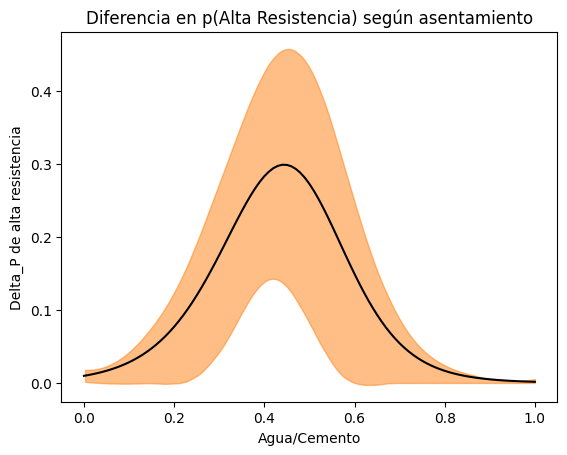

In [128]:
#  Hago la resta
p_diff = new_fitted.posterior['p'][:,:,df_2['Slump_cm']==5].values-new_fitted.posterior['p'][:,:,df_2['Slump_cm']==15].values

# Grafico la resta de #p# en funcion del agua sobre cemento
ax = az.plot_hdi(df_2[df_2['Slump_cm']==5]['Water'],p_diff,hdi_prob=0.8)
plt.plot(df_2[df_2['Slump_cm']==15]['Water'],np.mean(p_diff,axis=(0,1)),'k-')

# Agrego datos al gráfico
plt.xlabel('Agua/Cemento')
plt.ylabel('Delta_P de alta resistencia')
plt.title('Diferencia en p(Alta Resistencia) según asentamiento')
plt.show()

plt.show()

Y ahora podríamos hacer un test de hipótesis e indicar en qué rangos de relación agua/cemento el asentamiento juega un rol importante para definir si el hormigón es de alta resistencia o no.

Para pensar, ¿por qué cree que esto ocurre?

### Otros comentarios (modelos) Finales



#### Regresión categórica (no binaria)

Hasta el momento vimos cómo modelar resultados binarios con Bambi, donde se utiliza la familia **Bernoulli**, pero en caso de querer hacerlo con un número arbitrario de resultados, la multivariada de la familia Bernoulli es la familia **categórica**.

Supongamos que tenemos las mismas variables: composición del hormigón y resultados de ensayo, pero además poseemos tres tipos de hormigón:
- hormigón convencional: HC
- hormigón liviano: con poliestireno expandido: HL1
- hormigón liviano: con leca o arcilla expandida: HL2

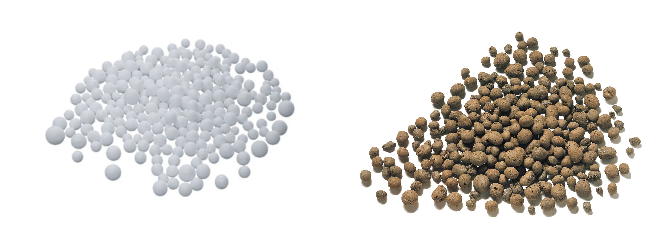

El modelo se define de manera muy similar a lo anterior:



```
# Modelo 2:
model_2 = bmb.Model('Concrete_category ~ CompressiveStrength', data, family="categorical", priors=priors)
```



En este tipo de modelos, donde hay más de una categoría (K categorías), la cantidad de parámetros se multiplica por (K-1), porque tengo que ajutar K-1 probabilidades (la que falta sale como 1 menos la sumatoria de las demás). La Bernoulli es simplemente un caso particular donde solo hay un valor de $p$ (o función $p(x)$) a ajustar.

####Regresión ordinal (Off-Road)

Otra situación que podría presentarse es modelizar Y, que se trata de un conjunto de categorías ordenadas. En este caso, si bien nos hacemos una idea de qué categoría es mayor a otra, no podemos establecer la diferencia entre ellas, de hecho, no necesariamente deben ser equidistantes.

Supongamos que ahora, en vez de la columna con el extendido y el asentamiento, tenemos una variable categórica con la consistencia del hormigón, resultando 5 categorías según la normativa nacional:
- Seca: un asentamiento menor a 4cm.
- Plástica: entre 5 y 9cm.
- Blanda: entre 10 y 15cm.
- Fluída:entre 16 y 21cm.
- Líquida: un asentamiento mayor a 24cm

In [ ]:
df_hormigon.loc[df_hormigon['Slump_cm'] <= 4, 'Consistency'] = "Seca"
df_hormigon.loc[(df_hormigon['Slump_cm'] > 5) & (df_hormigon['Slump_cm'] <= 9), 'Consistency'] = "Plástica"
df_hormigon.loc[(df_hormigon['Slump_cm'] > 10) & (df_hormigon['Slump_cm'] <= 15), 'Consistency'] = "Blanda"
df_hormigon.loc[(df_hormigon['Slump_cm'] > 16) & (df_hormigon['Slump_cm'] <= 21), 'Consistency'] = "Fluída"
df_hormigon.loc[df_hormigon['Slump_cm'] >= 24, 'Consistency'] = "Líquida"

A la columna `Consistency` la transformamos en tipo categórica e indicamos el orden de las mismas en `categories` e indicando `ordered=True`



In [ ]:
df_hormigon['Consistency'] = pd.Categorical(df_hormigon['Consistency'], categories=["Seca", "Plástica", "Blanda", "Fluída", "Líquida"], ordered=True)
df_hormigon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Cement               103 non-null    float64 
 1   Slag                 103 non-null    float64 
 2   Fly_ash              103 non-null    float64 
 3   Water                103 non-null    float64 
 4   Superplasticizer     103 non-null    float64 
 5   Coarse_aggr          103 non-null    float64 
 6   Fine_aggr            103 non-null    float64 
 7   Slump_cm             103 non-null    float64 
 8   Flow_cm              103 non-null    float64 
 9   CompressiveStrength  103 non-null    float64 
 10  Strength_Category    103 non-null    category
 11  Consistency          79 non-null     category
dtypes: category(2), float64(10)
memory usage: 8.7 KB


El modelo se define de manera muy similar a lo anterior, salvo que cambian las familias:
- `family = "cumulative"` si es acumulativo
- `family = "sratio"` si es secuencial.

#### En fin

A fin de cuentas, todo lo que vimos para modelos normales aplica a otras funciones de verosimilutd, como por ejemplo un modelo de bernoulli (lo que nos llevó a una regresión logística). La carga del modelo en general es siempre igual cambiando `family`, y la forma de interpretar (o entender efectos) también, con pequeñas particularidades según el caso.